In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'

In [3]:
ls /home/jupyter-mrayson/data/SWOT_Cruise/FV02/stacked_moorings_tp/

'[BB23]_[BB23_REC]_[N280]_[multi(27)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(27)_instrument_serial_number]_[no_outfile_append].nc'
'[BB23]_[BB23_REC]_[S245]_[multi(35)_nominal_instrument_height_asb]_[multi(2)_instrument_model]_[multi(35)_instrument_serial_number]_[no_outfile_append].nc'
'[BB23]_[BB23_REC]_[S245]_[multi(36)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(36)_instrument_serial_number]_[no_outfile_append].nc'
'[BB23]_[BB23_REC]_[S245]_[multi(37)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(37)_instrument_serial_number]_[no_outfile_append].nc'
'[BB23]_[BB23_REC]_[W310]_[multi(26)_nominal_instrument_height_asb]_[multi(4)_instrument_model]_[multi(26)_instrument_serial_number]_[no_outfile_append].nc'
'[BB23]_[BB23_REC]_[W310]_[multi(27)_nominal_instrument_height_asb]_[multi(5)_instrument_model]_[multi(27)_instrument_serial_number]_[no_outfile_append].nc'
 figures/


In [4]:
t1 = '2023-04-22 00:00:00'
t2 = '2023-05-31 23:59:00'

In [27]:
sitename='N280'
ncfile ='[BB23]_[BB23_REC]_[N280]_[multi(27)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(27)_instrument_serial_number]_[no_outfile_append].nc'

# sitename='W310'
# ncfile = '[BB23]_[BB23_REC]_[W310]_[multi(27)_nominal_instrument_height_asb]_[multi(5)_instrument_model]_[multi(27)_instrument_serial_number]_[no_outfile_append].nc'

# sitename='S245'
# ncfile = '[BB23]_[BB23_REC]_[S245]_[multi(35)_nominal_instrument_height_asb]_[multi(2)_instrument_model]_[multi(35)_instrument_serial_number]_[no_outfile_append].nc'
## ds = xr.open_dataset('/home/jupyter-mrayson/data/SWOT_Cruise/FV02/stacked_moorings_tp/[BB23]_[BB23_REC]_[S245]_[multi(36)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(36)_instrument_serial_number]_[no_outfile_append].nc')
## ds = xr.open_dataset('/home/jupyter-mrayson/data/SWOT_Cruise/FV02/stacked_moorings_tp/[BB23]_[BB23_REC]_[S245]_[multi(37)_nominal_instrument_height_asb]_[multi(3)_instrument_model]_[multi(37)_instrument_serial_number]_[no_outfile_append].nc')

ds_ = xr.open_dataset('/home/jupyter-mrayson/data/SWOT_Cruise/FV02/stacked_moorings_tp/'+ncfile)                     
ds = ds_.sel(time=slice(t1,t2))

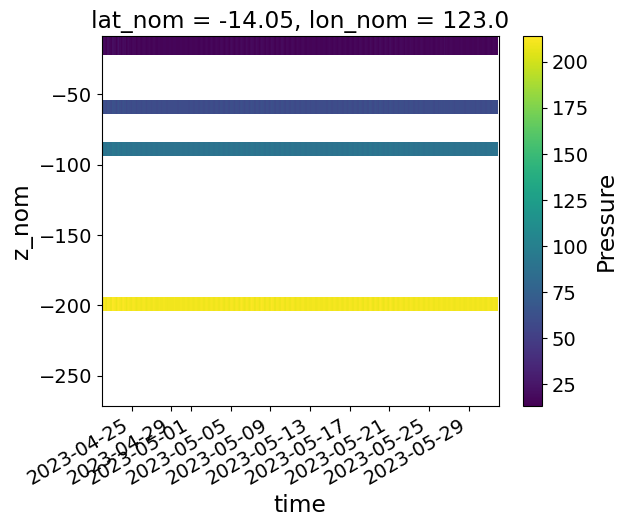

In [28]:
ds['Pressure'].plot()

# Compute Steric height


~~SSH_s =  \int_{-H}^0 \frac{\rho^{\prime}}{\rho_0} dz~~

$$
SSH_s =  -\int_{-H}^0 \frac{\rho^{\prime}}{\rho_0} dz
$$

where 

$$
\rho^{\prime} = \alpha \rho_0 (T-\overline{T})
$$
and
$$
\overline{T} = \frac{1}{\tau}\int_{0}^\tau T d\tau'
$$

 - $\tau$ is the record time length
 - $\alpha=-2\times 10^{-5}$ is the coefficient of expansion

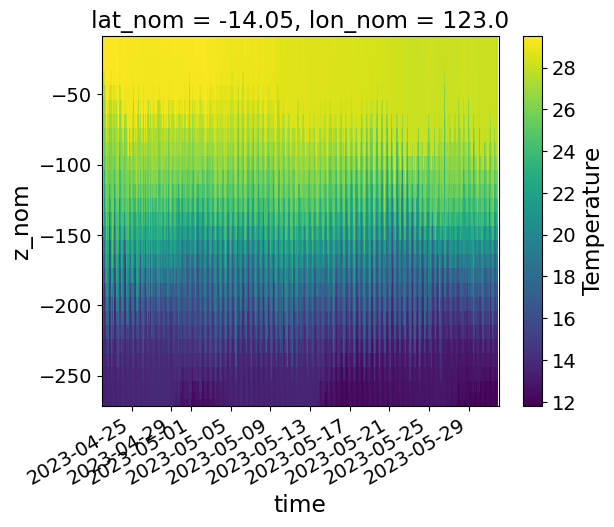

In [29]:
plt.figure()
ds['Temperature'].plot()

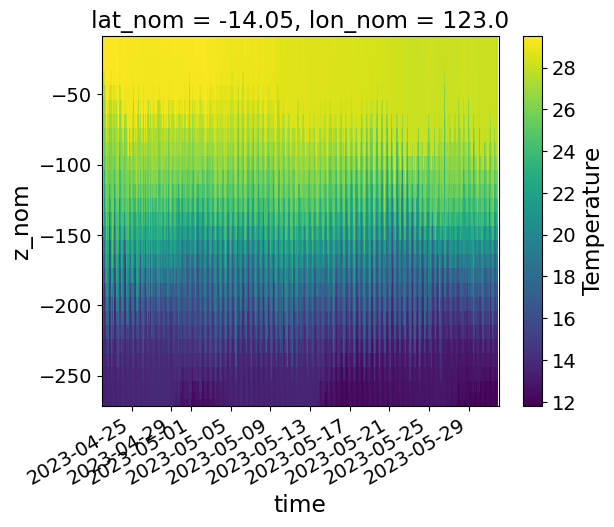

In [30]:
T_fill = ds['Temperature'].interpolate_na('z_nom', method='linear',fill_value='extrapolate')

T_fill.plot()

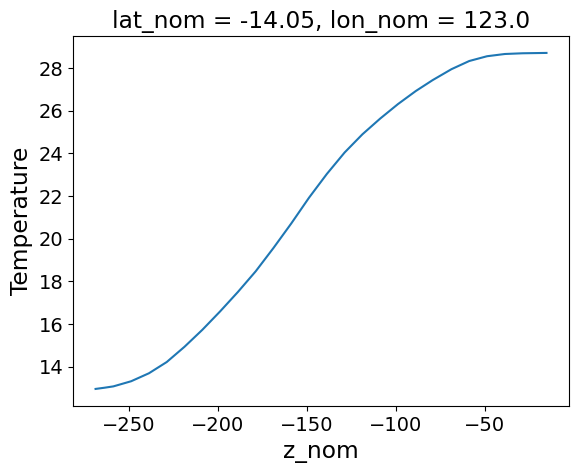

In [31]:
# T_bar = ds['Temperature'].mean(axis=1)
T_bar = T_fill.mean(axis=1)
T_bar.plot()


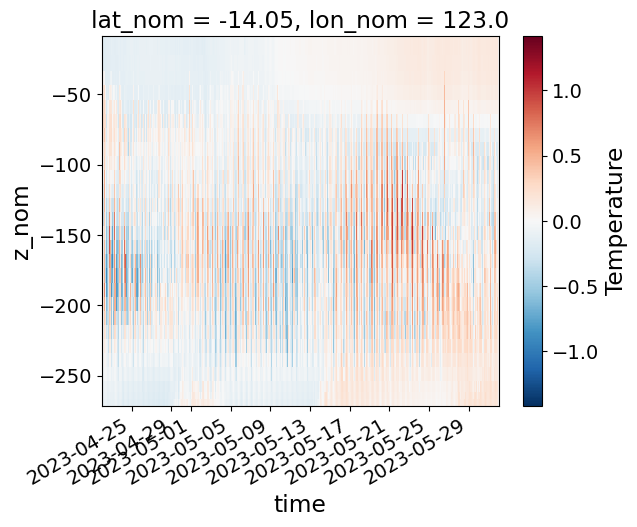

In [32]:
# Calculate rho_pr
# T_pr = ds['Temperature'] - T_bar
T_pr = T_fill - T_bar

alpha = -2.e-4
rho0 = 1024
rho_pr = alpha*T_pr*rho0

rho_pr = xr.where(np.isnan(rho_pr), 0, rho_pr)
rho_pr.plot()

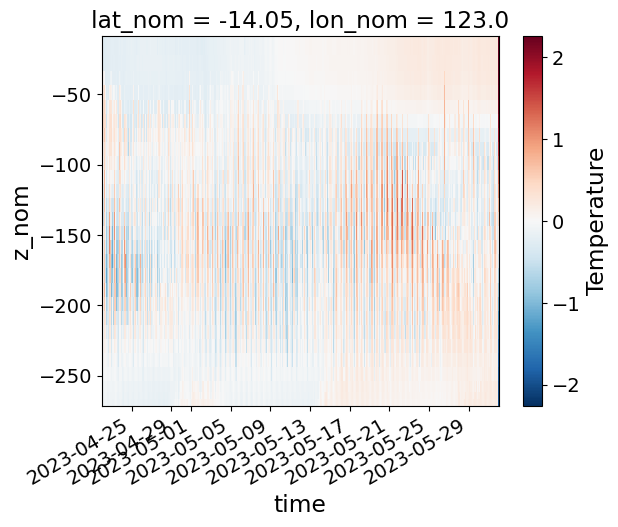

In [33]:
# Nonlinear EOS
import gsw

rho = gsw.pot_rho_t_exact( 34.6, T_fill,-ds['z_nom'], 0)

rho = xr.where(np.isnan(rho), rho0, rho)

rho_bar = rho.mean(axis=1)

rho_pr2 = rho - rho_bar

rho_pr2.plot()

In [34]:
# Calculate the vertical grid spacing
z_top = 0
z_bot = -280

z_mid = 0.5*(ds['z_nom'][0:-1].values + ds['z_nom'][1:].values)
z_mid.shape, ds['z_nom'].shape

z = np.hstack([[z_bot], z_mid, [z_top]])

dz = z[1:] - z[0:-1]
dz

array([13.682 ,  5.    ,  7.5   , 10.    , 10.    , 10.    , 10.    ,
       10.    , 10.    , 10.    , 10.    , 10.    , 10.    , 10.    ,
       10.    , 10.    , 10.    , 10.    , 10.    ,  9.75  , 10.0345,
       10.2845, 10.    , 10.    , 10.    , 11.7   , 22.049 ])

(array([19469., 19478., 19485., 19492., 19499., 19509.]),
 [Text(19469.0, 0, '2023-04-22'),
  Text(19478.0, 0, '2023-05-01'),
  Text(19485.0, 0, '2023-05-08'),
  Text(19492.0, 0, '2023-05-15'),
  Text(19499.0, 0, '2023-05-22'),
  Text(19509.0, 0, '2023-06-01')])

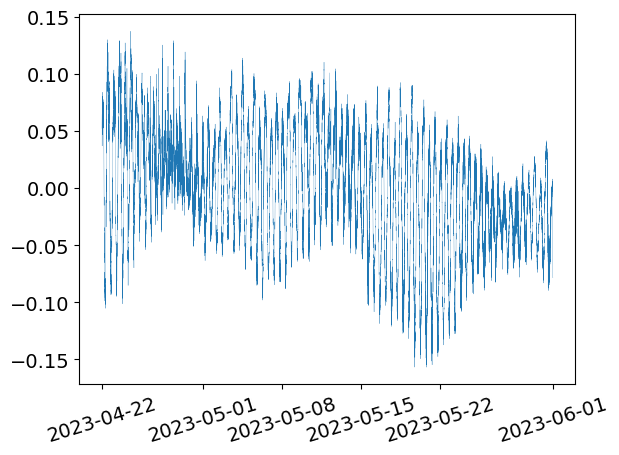

In [35]:
#ssh=np.sum(rho_pr2/rho0*dz[:,None], axis=0)
ssh=-np.sum(rho_pr2/rho0*dz[:,None], axis=0) # !! Note the negative !!

plt.plot(ds.time, ssh,      lw =0.2)
plt.xticks(rotation=17)

In [36]:
ds.time[-1].values

numpy.datetime64('2023-05-31T23:59:00.000000000')

In [37]:
outfile = '../DATA/mooring_steric_ssh_{}_v3.nc'.format(sitename)

rho_pr['name'] = 'rho_pr'
rho_pr.attrs = {'long_name':'density fluctuation', 'units':'kg m-3',
               'equation_of_state':'linear','alpha':alpha,'rho0':rho0}

da_ssh = xr.DataArray(ssh, coords={'time':ds.time},
                     attrs={'long_name':'steric height', 'units':'m'})


ds_Tbar = xr.DataArray(rho_bar, coords={'z_nom':ds.z_nom},
                       attrs={'long_name':'background density', 'units':'kg m-3'})

ds_out = xr.Dataset({'eta_steric':da_ssh, 'rho_pr':rho_pr2, 'rho_background':ds_Tbar})

ds_out.attrs = {'original file':ncfile}

ds_out.to_netcdf(outfile)
print(outfile)
ds_out


../DATA/mooring_steric_ssh_N280_v3.nc


<xarray.Dataset>
Dimensions:         (time: 57600, z_nom: 27)
Coordinates:
  * time            (time) datetime64[ns] 2023-04-22 ... 2023-05-31T23:59:00
  * z_nom           (z_nom) float64 -268.8 -263.8 -258.8 ... -28.75 -15.35
    lat_nom         float64 -14.05
    lon_nom         float64 123.0
Data variables:
    eta_steric      (time) float64 0.05207 0.06148 0.05717 ... -0.07824 -0.07824
    rho_pr          (z_nom, time) float64 -0.08439 -0.08484 ... 2.256 2.256
    rho_background  (z_nom) float64 1.026e+03 1.026e+03 ... 1.022e+03 1.022e+03
Attributes:
    original file:  [BB23]_[BB23_REC]_[N280]_[multi(27)_nominal_instrument_he...

# Old stuff...

In [47]:
outfile = '../DATA/mooring_steric_ssh_{}_v1.nc'.format(sitename)

rho_pr['name'] = 'rho_pr'
rho_pr.attrs = {'long_name':'density fluctuation', 'units':'kg m-3',
               'equation_of_state':'linear','alpha':alpha,'rho0':rho0}

da_ssh = xr.DataArray(ssh, coords={'time':ds.time},
                     attrs={'long_name':'steric height', 'units':'m'})


ds_Tbar = xr.DataArray(T_bar, coords={'z_nom':ds.z_nom},
                       attrs={'long_name':'background temperature', 'units':'degrees C'})

ds_out = xr.Dataset({'eta_steric':da_ssh, 'rho_pr':rho_pr, 'T_background':ds_Tbar})

ds_out.attrs = {'original file':ncfile}

ds_out.to_netcdf(outfile)
print(outfile)
ds_out


PermissionError: [Errno 13] Permission denied: '/data/jupyter-ubuntu/ProjectsActive/SWOT_NAust/DATA/mooring_steric_ssh_W310_v1.nc'

In [ ]:


def calc_ssh_bc_xarray(outpath, ss, tstart):
    omrho= xr.open_dataset('{}/IMOS_Stack_Mooring_{}_{}_{}_Tonly_60s.nc'.format(outpath, ss, tstart, 'RHO'))

    omrho_fill = omrho['rho'].interpolate_na('time', method='nearest',fill_value='extrapolate')

    dt = 60
    cutoff_dt = 34*3600.
    rho_lf = filt(omrho_fill.values, cutoff_dt, dt, btype='low', order=3, ftype='ba', axis=-1)

    cutoff_dt2 = 6*3600.
    rho_tidal = filt(omrho_fill.values, cutoff_dt2, dt, btype='low', order=3, ftype='ba', axis=-1)

    g = 9.81
    rho0 = 1024.
    b = om.OceanMooring(omrho.time.values[::10], -g*(rho_tidal[:,::10] - rho_lf[:,::10])/rho0, omrho.depth.values, positive='down')

    p_surf, _ = b.depthint(ztop=0)
    p_surf *= rho0
    ssh_bc = om.OceanMooring(b.t, p_surf/(rho0*g), np.array([0]) )

    # QC based on nans in the original file
    badidx = np.isnan(omrho.rho.values)
    mybad = np.any(badidx,axis=0)[::10] 
    ssh_bc.y[mybad] = np.nan
    